In [1]:
# pytorch
import torch
import torch.nn as nn
# Mobile Net
# from MobileNetV2 import mobilenet_v2
from MobileNetV3 import mobilenetv3_large, mobilenetv3_small
# dataset
from torchvision import datasets
from torchvision import transforms
# dataloader
from torch.utils.data import DataLoader
# Util
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
# tensorboard
from torch.utils.tensorboard import SummaryWriter
# plt
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
matplotlib.rcParams.update({'font.size': 13})
import scipy.io as scio
from scipy.io import loadmat
from sklearn.model_selection import KFold

In [2]:
# loss下降曲线vec
loss_vec4 = []
loss_vec8 = []
loss_vec16 = []
loss_vec32 = []
loss_vec64 = []
acc_vec = []

In [3]:
# 超参数
input_size = 224
batch_size = 32
n_worker = 8
lr = 0.001
epochs = 50

In [4]:
# 生成训练数据集
train_path = "image/train_image"
test_path = "image/test_image"
# val_path = "Image/val_image"
data_transform = transforms.Compose([
        transforms.Resize([input_size, input_size]),
        transforms.ToTensor(),
])
train_dataset = datasets.ImageFolder(train_path, transform=data_transform)
test_dataset = datasets.ImageFolder(test_path, transform=data_transform)
# val_dataset = datasets.ImageFolder(val_path, transform=data_transform)

In [5]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=n_worker, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=20, shuffle=False, 
    num_workers=n_worker)
# val_loader = DataLoader(
    # val_dataset, batch_size=batch_size, shuffle=False, 
    # num_workers=n_worker)

In [6]:
model = mobilenetv3_large()
# model = mobilenet_v2()
model.classifier[3] = nn.Linear(1280, 90)
model = model.cuda(3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
best_model_wts = copy.deepcopy(model.state_dict())
# writer = SummaryWriter()

In [7]:
def train(epoch, model):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(3), label.cuda(3)
        # clear the grad
        optimizer.zero_grad()
        output = model(data)
        # loss function
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    # writer.add_scalar("Loss/train", train_loss, epoch)
    loss_vec32.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [8]:
def val(epoch, model):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.cuda(3), label.cuda(3)
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(val_loader.dataset)
    # writer.add_scalar("Loss/val", val_loss, epoch)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    # writer.add_scalar("Acc/train", acc, epoch)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [16]:
def test(epoch, model):
    model = model.cuda(3)
    model.eval()
    idx = 0
    ans = 0.0
    best_acc = 0.0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cuda(3), label.cuda(3)
            output = model(data)
            preds = torch.argmax(output, 1)
            unique_values, counts = torch.unique(preds, return_counts=True)
            pres = unique_values[counts.argmax()]
            if pres.item() == idx:
                ans += 1
            idx += 1
    acc = ans / 90
    if acc > best_acc:
        best_model_wts = copy.deepcopy(model.state_dict())
    acc_vec.append(acc)
    print('Epoch: {} Accuracy: {:6f}'.format(epoch, acc))
    return acc

In [10]:
start_time = time.time()
for epoch in range(1, epochs + 1):
    train(epoch, model)
    # test(epoch, model)
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Training time {total_time_str}")

Epoch: 1 	Training Loss: 4.066934
Epoch: 2 	Training Loss: 3.287932
Epoch: 3 	Training Loss: 2.794898
Epoch: 4 	Training Loss: 2.417734
Epoch: 5 	Training Loss: 2.130980
Epoch: 6 	Training Loss: 1.809242
Epoch: 7 	Training Loss: 1.671545
Epoch: 8 	Training Loss: 1.408329
Epoch: 9 	Training Loss: 1.195447
Epoch: 10 	Training Loss: 1.043070
Epoch: 11 	Training Loss: 0.916175
Epoch: 12 	Training Loss: 0.803879
Epoch: 13 	Training Loss: 0.712633
Epoch: 14 	Training Loss: 0.635788
Epoch: 15 	Training Loss: 0.540527
Epoch: 16 	Training Loss: 0.498531
Epoch: 17 	Training Loss: 0.447252
Epoch: 18 	Training Loss: 0.420276
Epoch: 19 	Training Loss: 0.401784
Epoch: 20 	Training Loss: 0.369488
Epoch: 21 	Training Loss: 0.418942
Epoch: 22 	Training Loss: 0.333833
Epoch: 23 	Training Loss: 0.249175
Epoch: 24 	Training Loss: 0.317238
Epoch: 25 	Training Loss: 0.235134
Epoch: 26 	Training Loss: 0.206162
Epoch: 27 	Training Loss: 0.161838
Epoch: 28 	Training Loss: 0.243124
Epoch: 29 	Training Loss: 0.2

In [17]:
start_time = time.time()
test(1, model)
total_time = time.time() - start_time
print(total_time)

Epoch: 1 Accuracy: 0.933333
2.2484042644500732


In [15]:
def getModelSize(model):
    param_size = 0
    param_sum = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
        param_sum += param.nelement()
    buffer_size = 0
    buffer_sum = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        buffer_sum += buffer.nelement()
    all_size = (param_size + buffer_size) / 1024 / 1024
    print('模型总大小为：{:.3f}MB'.format(all_size))
    return (param_size, param_sum, buffer_size, buffer_sum, all_size)

getModelSize(model)

模型总大小为：16.563MB


(17269288, 4317322, 97968, 24446, 16.562705993652344)

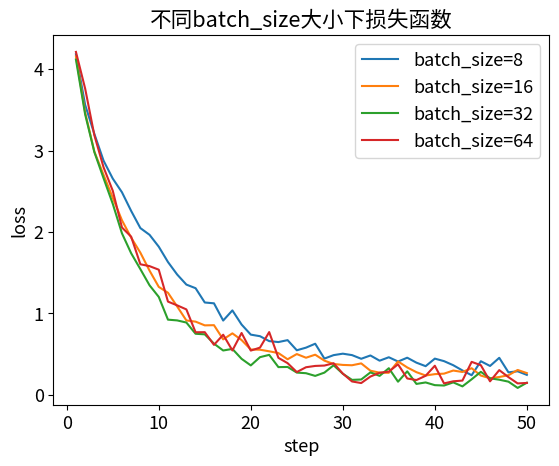

In [65]:
# show train pic
plt.ylabel("loss")
plt.xlabel("step")
plt.title("不同batch_size大小下损失函数")
# plt.plot(list(range(1, 23)), loss_vec4, label='batch_size=4')
plt.plot(list(range(1, 51)), loss_vec8, label='batch_size=8')
plt.plot(list(range(1, 51)), loss_vec16, label='batch_size=16')
plt.plot(list(range(1, 51)), loss_vec32, label='batch_size=32')
plt.plot(list(range(1, 51)), loss_vec64, label='batch_size=64')
plt.legend()
plt.show()
# matrix = np.mat([loss_vec4, loss_vec8, loss_vec16, loss_vec32])
# scio.savemat('batch_size.mat', {'data': matrix})

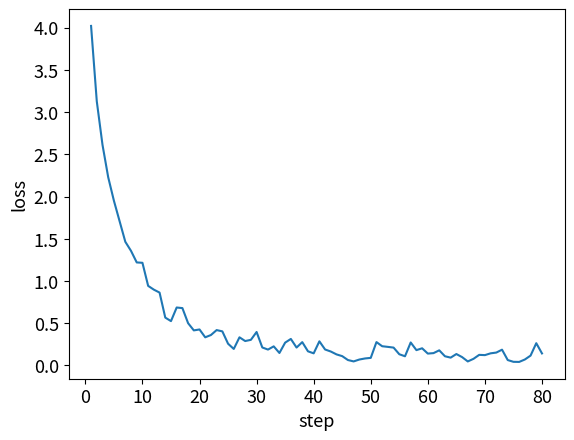

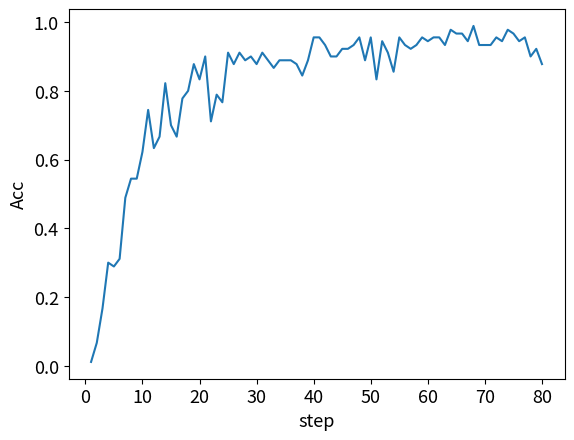

In [14]:
# 训练结果图
plt.ylabel("loss")
plt.xlabel("step")
plt.plot(list(range(1, 81)), loss_vec32)
plt.show()

plt.ylabel("Acc")
plt.xlabel("step")
plt.plot(list(range(1, 81)), acc_vec)
plt.show()

In [14]:
s = time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime())
torch.save(best_model_wts, f'save_model/float/ecgid_model_{s}.pt')